# PEFT for GAI Homework3



## 作業目標


## 套件 Dependency
* 如果使用 colab 或 kaggle -> `執行以下block`
* 一般執行環境 -> `pip install -r requirements.txt`


In [41]:
!pip install peft

In [42]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader

import transformers as T

from peft import get_peft_model, LoraConfig

# 分類與迴歸任務
## 準備資料集 (需先下載)
- CoLA 資料集
    - https://dl.fbaipublicfiles.com/glue/data/CoLA.zip
    - 二分類任務
    - 預測句子的可接受程度，合乎文法與不合乎文法
    - 資料不具欄位名稱 -> 定義為 `label` 與 `sentence`
    - 評價指標為 Matthew's Corr

- STS-B 資料集
    - https://dl.fbaipublicfiles.com/glue/data/STS-B.zip
    - 迴歸任務
    - 預測兩個句子的相似度，區間為0-5的浮點數
    - 句子分別由 `sentence1` 與 `sentence2` 兩欄位表示，相似度分數在 `score` 欄位
    - 評價指標為 Pearson-Spearman Corr


以下區塊為設定執行的實驗規格
- 資料集名稱二選一
- huggingface 模型名稱
- bitfit、lora、finetune 三選一
- 偏好的 random seed

In [43]:
#@title  { display-mode: "form" }
DATA_NAME = "STS-B"         #@param ["CoLA", "STS-B"] {type:"string"}
MODEL_NAME = "roberta-base" #@param  {type:"string"}
PEFT_TYPE = "lora"        #@param ["lora", "bitfit", "full-finetune"] {type:"string"}
RANDOM_SEED = 42            #@param  {type:"integer"}

In [44]:
# 對資料集產生對應的下載網址
filename = f"https://dl.fbaipublicfiles.com/glue/data/{DATA_NAME}.zip"

# 解壓縮後的檔名
entry =  DATA_NAME

# splits -> 資料集的分割名稱
splits = ["train", "dev"]

# 設定執行環境 (CPU or GPU)
device = "cpu" if torch.cuda.is_available() else "cuda"
dataset_dict = dict()

### 下載資料與解壓縮

In [45]:
# 確認是否已下載資料 (執行多次時可以避免一直下載)
if not os.path.isfile(f"{DATA_NAME}.zip"):
    # 下載資料集
    os.system(f"wget {filename}")
    # 解壓縮
    os.system(f"unzip {DATA_NAME}.zip")

### 讀取資料
包括 train, dev, test 三種分割資料

In [46]:
# 讀取所有 splits 資料
if DATA_NAME == "STS-B":
    for split_type in splits:
        dataset_dict[split_type] = pd.read_csv(
            os.path.join(entry, (split_type + ".tsv")),
            sep="\t", on_bad_lines='skip'
        )
else:
    for split_type in splits:
        dataset_dict[split_type] = pd.read_csv(
            os.path.join(entry, (split_type + ".tsv")),
            sep="\t", on_bad_lines='skip',
            usecols=[1,3],
            names=['label', 'sentence'], header=None
        )

## Task 1: 資料載入
本次作業要求選擇GLUE benchmark中的資料集至少兩個
* 使用 torch dataset 封裝資料
* 根據兩種不同的資料進行tokenize

In [47]:
class CustomedDataset(Dataset):

    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = { key: torch.tensor(val[idx]) for key, val in self.encodings.items() }
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# tokenize 資料
def process_dataset(df, tokenizer):

    # 避免資料中有 na
    df = df.dropna(ignore_index=True)

    texts = []
    labels = None

    if DATA_NAME == "CoLA":
        # CoLA 會將句子放在 sentence 欄位、標籤放在 label
        for s in df["sentence"]:
            s = s.strip() # 除去不必要的空白
            # 包裝輸入成 tokenizer 預期的輸入
            ### <s>  : 句子開頭
            ### </s> : 句子結尾
            texts.append(f"<s> {s} </s>")

        labels = df["label"]

    else:
        # STSB 會將句子放在 sentence1, sentence2 欄位、標籤放在 score
        for s1, s2 in zip( df["sentence1"], df["sentence2"] ):
            s1 = s1.strip() # 除去不必要的空白
            s2 = s2.strip() # 除去不必要的空白
            # 包裝輸入成 tokenizer 預期的輸入
            ### <s>  : 句子開頭
            ### </s> : 句子分割與結尾
            texts.append(f"<s> {s1} </s></s> {s2} </s>")

        labels = df["score"]

    encodings = tokenizer(
        texts, truncation=True, padding=True,
        add_special_tokens=False                # 關閉 add_special_tokens -> 已經預處理時加入<s>, </s>
    )

    # 回傳的 label 分兩種格式
    ##### 分類 -> int
    ##### 回歸 -> float
    return {
        "encodings": encodings,
        "labels": labels.astype(int) if DATA_NAME == "CoLA" else labels.astype(np.float32)
    }

### Hugging Face
- load Model
- load Tokenizer

In [48]:
# 定義不同資料集的label數量(1 -> regression -> MSELoss)
num_labels = 2 if DATA_NAME != "STS-B" else 1
# 讀入 huggingface 的 model 與 tokenizer
model = T.AutoModelForSequenceClassification.from_pretrained( MODEL_NAME, num_labels=num_labels )
tokenizer = T.AutoTokenizer.from_pretrained( MODEL_NAME )

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 處理資料
* 查看資料的數量
* 轉換資料到 torch 格式

In [49]:
# 輸出資料集數量
print("training size:  ", len(dataset_dict["train"]))
print("evaluation size:", len(dataset_dict["dev"]))

training size:   5706
evaluation size: 1465


In [50]:
# 從 dataframe 轉換到 torch dataset
train_dataset = CustomedDataset( **process_dataset(dataset_dict["train"], tokenizer) )
dev_dataset = CustomedDataset( **process_dataset(dataset_dict["dev"], tokenizer) )

## Task2: 模型驗證
根據兩種資料集傳回不同的評價指標
* CoLA : matthews
* STS-B: spearman

In [51]:
from sklearn.metrics import matthews_corrcoef
from scipy.stats import spearmanr

# 請參考GLUE benchmark的官方網頁，使用和資料集對應的evaluation matrics
### 本次資料集用到兩個 coefficient 分數
###### CoLA => matthews
###### STS-B => spearman

def compute_metrics(pred):

    # pred 可以透過 label_ids 和 predictions 分別取得類別與預測結果
    labels = pred.label_ids
    # preds 紀錄預測的結果 / score 紀錄真實標籤值
    preds = None
    score = None

    if DATA_NAME != "STS-B":
        # CoLA 資料集為分類任務需要找出預測分數最高的類別
        preds = pred.predictions.argmax(-1)
        score = matthews_corrcoef(labels, preds)
    else:
        # STS-B 是迴歸任務只需取出預測值即可
        preds = pred.predictions[:, 0]
        score = spearmanr(labels, preds).statistic

    if np.isnan(score): # 避免相關係數有 nan 出現
        score = 0

    # 根據資料集需求回傳對應格式 (分數名稱: 分數)
    return {"matthews-corr": score} if DATA_NAME != "STS-B" else {"pearson-corr": score}

## Task3: PEFT
在這個模塊中，我們要求同學們把模型改成PEFT的形式（Bitfit、LoRA或者其他）\
同學們可以將模型的可訓練參數量print出來

以下是2個資料集的baseline:

|dataset|metrics|baseline|
|----|----|----|
|CoLA|Matthew's Corr|0.6|
|STSB|Pearson-Spearman Corr|0.8|

以下區塊為設定執行的LoRA參數 (有需要跑lora時再改)
- rank
- alpha
- dropout

In [52]:
#@title  { display-mode: "form" }
lora_rank       = 256      #@param  {type:"integer"}
lora_alpha      = 8     #@param  {type:"number"}
lora_dropout    = 0.1    #@param  {type:"number"}

將參數轉換為字典形式 -> 之後輸入給 peft LoraConfig

In [53]:
lora_config = {
    "r": lora_rank,
    "lora_alpha": lora_alpha,
    "lora_dropout": lora_dropout
}

計算可訓練的參數量

In [54]:
def show_trainable_ratio(model):
    # 取得可訓練與不可訓練的參數量
    trainbale_params = model.num_parameters(only_trainable=True)
    all_params = model.num_parameters(only_trainable=False)

    # 設定與 peft 相同的輸出格式 ( {trainable} || {all} || {trainable%})
    ### :, -> 設定輸出格式千分位
    return f"trainable params: {trainbale_params:,} || all params: {all_params:,} || trainable%: {trainbale_params/all_params*100:.6f}"

### peft 設置
- 根據設定凍結PLM參數或是添加額外參數
- 並輸出可訓練參數

In [55]:
if PEFT_TYPE == "lora":
    # LoRA -> 採用 peft 套件的設定
    model = get_peft_model(model, LoraConfig(**lora_config))

elif PEFT_TYPE == "bitfit":
    # 凍結非 bias 的參數
    for name, param in model.named_parameters():
        if "bias" not in name:
            param.requires_grad = False
else:
    # full finetune 不用做任何改動
    pass

# 輸出可訓練的參數佔比
print(show_trainable_ratio(model))

trainable params: 9,437,184 || all params: 134,083,585 || trainable%: 7.038284


### 設定訓練時參數

In [56]:
#@title  { display-mode: "form" }
num_train_epochs                = 10         #@param  {type:"integer"}
learning_rate                   = 4e-4      #@param  {type:"number"}
per_device_train_batch_size     = 16        #@param  {type:"integer"}
per_device_eval_batch_size      = 16        #@param  {type:"integer"}
gradient_accumulation_steps     = 1         #@param  {type:"integer"}
warmup_steps                    = 200      #@param  {type:"integer"}
weight_decay                    = 0.1      #@param  {type:"number"}
evaluation_strategy             = "steps"   #@param ["steps", "no", "epoch"] {type:"string"}
save_strategy                   = "steps"   #@param ["steps", "no", "epoch"] {type:"string"}
save_steps                      = 150      #@param  {type:"integer"}
eval_steps                      = 150      #@param  {type:"integer"}
adam_epsilon                    = 1e-6      #@param  {type:"number"}
save_total_limit                = 2         #@param  {type:"integer"}
logging_steps                   = 150      #@param  {type:"integer"}

將訓練參數轉為字典 -> 之後傳給 `TrainingArguments`

In [57]:
training_args = {
    "output_dir"                    :   DATA_NAME,                  # 設定輸出位置
    "seed"                          :   RANDOM_SEED,                # 設定亂數種子
    "report_to"                     :   "none",
    "label_names"                   :   ["labels"],
    "num_train_epochs"              :   num_train_epochs,
    "learning_rate"                 :   learning_rate,
    "per_device_train_batch_size"   :   per_device_train_batch_size,
    "per_device_eval_batch_size"    :   per_device_eval_batch_size,
    "gradient_accumulation_steps"   :   gradient_accumulation_steps,
    "warmup_steps"                  :   warmup_steps,
    "weight_decay"                  :   weight_decay,
    "adam_epsilon"                  :   adam_epsilon,
    "evaluation_strategy"           :   evaluation_strategy,
    "save_strategy"                 :   save_strategy,
    "save_steps"                    :   save_steps,
    "eval_steps"                    :   eval_steps,
    "save_total_limit"              :   save_total_limit,
    "logging_steps"                 :   logging_steps
}

### 開始訓練

In [58]:
trainer = T.Trainer(
    model=model,                                        # 🤗 的模型
    args=T.TrainingArguments(**training_args),          # Trainer 所需要的引數
    train_dataset=train_dataset,                        # 訓練集 (注意是 PyTorch Dataset)
    eval_dataset=dev_dataset,                           # 驗證集 (注意是 PyTorch Dataset)，可使 Trainer 在進行訓練時也進行驗證
    compute_metrics=compute_metrics,                    # 自定的評估的指標
)

# 指定使用 1 個 GPU 進行訓練
trainer.args._n_gpu=1

# 開始進行模型訓練
trainer.train()

Step,Training Loss,Validation Loss,Pearson-corr
150,5.419100,2.786229,0.164588
300,1.570500,0.802559,0.818322
450,0.791400,0.631251,0.872069
600,0.682900,0.535759,0.882319
750,0.604900,0.539252,0.887478
900,0.496300,0.784896,0.875454
1050,0.520700,0.615916,0.891415
1200,0.464600,0.485444,0.896395
1350,0.455100,0.547209,0.889596
1500,0.429000,0.522328,0.895802


TrainOutput(global_step=3570, training_loss=0.6717076523297307, metrics={'train_runtime': 4327.7733, 'train_samples_per_second': 13.178, 'train_steps_per_second': 0.825, 'total_flos': 1.48689655309017e+16, 'train_loss': 0.6717076523297307, 'epoch': 10.0})

### 視覺化訓練過程

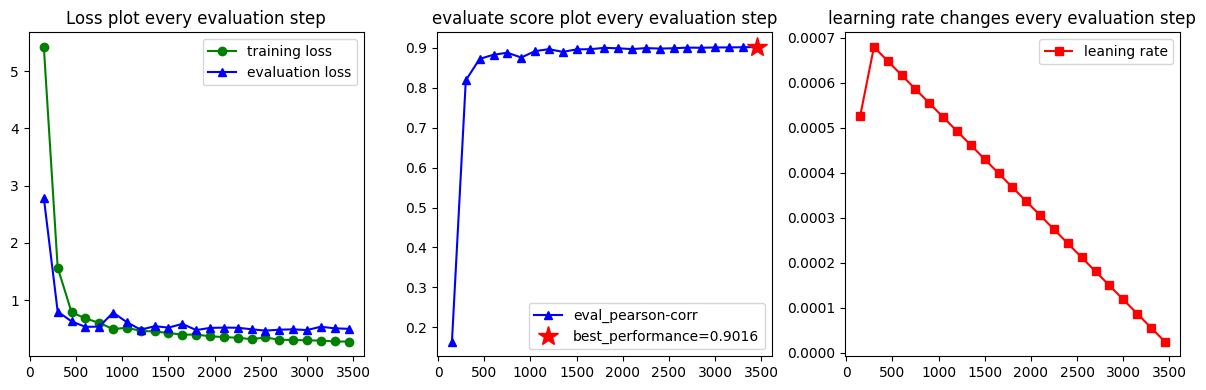

In [60]:
## 需要分析的值
eval_steps = []
train_losses = []
eval_losses = []
eval_scores = []
learning_rates = []
# score_name 用來取得紀錄名稱
score_name = "eval_matthews-corr" if DATA_NAME != "STS-B" else "eval_pearson-corr"

# 每兩個一組 -> i: training 資料 / i+1: evaluate 資料
for i in range(0, len(trainer.state.log_history)-1, 2):
    train_losses.append(trainer.state.log_history[i]["loss"])
    learning_rates.append(trainer.state.log_history[i]["learning_rate"])
    eval_losses.append(trainer.state.log_history[i+1]["eval_loss"])
    eval_scores.append(trainer.state.log_history[i+1][score_name])
    eval_steps.append(trainer.state.log_history[i+1]["step"])

plt.figure(figsize=(12,4))
plt.subplot(131)
plt.title("Loss plot every evaluation step")
plt.plot(eval_steps, train_losses, "go-", label="training loss")
plt.plot(eval_steps, eval_losses, "b^-", label="evaluation loss")
plt.legend()
plt.subplot(132)
plt.title("evaluate score plot every evaluation step")
best_step = np.argmax(eval_scores)
plt.plot(eval_steps, eval_scores, "b^-", label=score_name)
plt.plot([eval_steps[best_step]], [eval_scores[best_step]], "r*", markersize=15, label=f"best_performance={eval_scores[best_step]:.4f}")
plt.legend()
plt.subplot(133)
plt.title("learning rate changes every evaluation step")
plt.plot(eval_steps, learning_rates, "rs-", label="leaning rate")
plt.legend()
plt.tight_layout()
plt.show()

清除不需要的空間與資源

In [61]:
del model, tokenizer, trainer
torch.cuda.empty_cache()